# Motor Identification

In [24]:
import sys
sys.path.append('..')

In [25]:
%matplotlib inline  
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
import time

In [26]:
from ctrl.system.tf import PID
from ctrl.block.linear import Gain, Feedback
from ctrl.block.logger import Logger

In [27]:
from ctrl.client import Controller
HOST, PORT = "192.168.10.102", 9999
HOST, PORT = "localhost", 9999
controller = Controller(host = HOST, port = PORT)

##Static Reponse

In [28]:
controller.reset()
controller.add_sink('logger', 
                    Logger(), 
                    ['clock', 'encoder1','motor1'])

In [29]:
print(controller.info('all'))

> Controller with 5 signal(s), 1 source(s), 1 sink(s), and 2 filter(s)
> period = 0.01s
> signals
  1. clock
  2. motor1
  3. encoder1
  4. pot1
  5. input1
> sources
  1. clock[enabled] >> clock
> filters
  1. motor1 >> dz1[enabled] >> input1
  2. input1 >> model1[enabled] >> encoder1
> sinks
  1. clock, encoder1, motor1 >> logger[enabled]



In [30]:
print('> Identifying motor static response')
controller.set_sink('logger',reset=True)
dT = 3
dD = 5
ts = []
with controller:
    time.sleep(1)
    for duty_cycle in range(0,100+dD,dD):
        print('\r  duty cycle = {}%'.format(100-duty_cycle), end='')
        ts.append(controller.get_signal('clock'))
        controller.set_signal('motor1', 100-duty_cycle)
        time.sleep(dT)
print('\n< Done')
print('> Retrieving data')
log = controller.read_sink('logger')
print('< Done')

> Identifying motor static response
  duty cycle = 0%
< Done
> Retrieving data
< Done


In [31]:
# Duration of transient
Tt = 1

In [32]:
t = log[:,0]
pos = log[:,1]
ref = log[:,2]

vel = np.zeros(t.shape, float)
vel[1:] = (pos[1:]-pos[:-1])/(t[1:]-t[:-1])

ssvel = np.array([])
sst = np.array([])
ssref = np.array([])
for (tk,tr) in zip(ts[:-1],ts[1:]):
    ind = np.where((t > tk + Tt)&(t < tr))
    sst = np.append(t[ind], sst)
    ssvel = np.append(vel[ind], ssvel)
    ssref = np.append(ref[ind], ssref)

/Users/mauricio/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: divide by zero encountered in true_divide


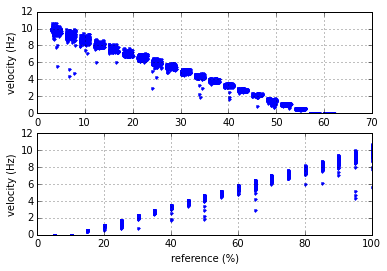

In [33]:
plt.subplot(2,1,1)
plt.plot(sst, ssvel, '.')
plt.xlabel('t (s)')
plt.ylabel('velocity (Hz)')
plt.grid()

plt.subplot(2,1,2)
plt.plot(ssref, ssvel, '.')
plt.xlabel('reference (%)')
plt.ylabel('velocity (Hz)')
plt.grid()

In [34]:
def func(x, a, v0):
    return a * (x - v0)

import scipy.optimize as optimize

ind = np.where(ssvel > 0)
pars, residues = optimize.curve_fit(func, ssref[ind], ssvel[ind])
a, v0 = pars.tolist()
print('a = {:4.3f}, v0 = {:4.3f}'.format(a,v0))

a = 0.106, v0 = 9.016


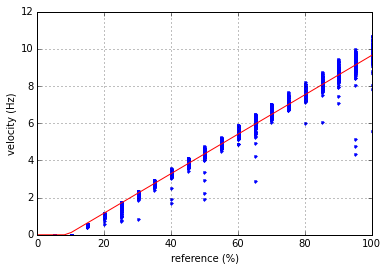

In [35]:
plt.plot(ssref, ssvel, '.', np.linspace(0,100), np.maximum(a * (np.linspace(0,100) - v0),0),'r-')
plt.xlabel('reference (%)')
plt.ylabel('velocity (Hz)')
plt.grid()

##Dynamic Response

With a constant input:
$$
\omega(t) = \bar{\omega} \left ( 1 - e^{\lambda t} \right )
$$
where:
$$
\begin{aligned}
\bar{\omega} &= a \, (v_a - v_0), & a &= \frac{k_m}{b_m}, & \lambda &= \frac{b_m}{J_m}
\end{aligned}
$$

In [36]:
print('> Identifying motor dynamic response')
K = 5
T0 = 1
T1 = 2
tref = []
duty = 90
with controller:
    controller.set_sink('logger',reset=True)
    for k in range(K):
        print('\r  Experiment #{}'.format(k+1),end='')
        time.sleep(T0)
        t0=controller.get_signal('clock')
        controller.set_signal('motor1',duty)
        time.sleep(T1)
        t1=controller.get_signal('clock')
        controller.set_signal('motor1',0)
        time.sleep(T0)
        tref.append((t0,t1))
print('\n< Done')
print('> Retrieving data')
log = controller.read_sink('logger')
print('< Done')

> Identifying motor dynamic response
  Experiment #5
< Done
> Retrieving data
< Done


In [37]:
t = log[:,0]
pos = log[:,1]
ref = log[:,2]

vel = np.zeros(t.shape, float)
vel[1:] = (pos[1:]-pos[:-1])/(t[1:]-t[:-1])

/Users/mauricio/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: divide by zero encountered in true_divide


In [38]:
Ts = controller.get_period()

In [39]:
N = 0
omegabar = 0
for (tk,tr) in tref:
    indss = np.where((t > tk+Tt) & (t < tr))
    nss = len(indss[0])
    omegabar += nss * np.mean(vel[indss])
    N += nss
omegabar /= N
print('N = {}, omegabar = {:5.3f}[{:5.3f}]'.format(N, omegabar, a * (duty-v0)))

N = 426, omegabar = 8.418[8.591]


In [40]:
N = 0
vtr = np.array([])
ttr = np.array([])
for (tk,tr) in tref:
    indtr = np.where((t > tk + Ts) & (t < tk+Tt))
    vtr = np.hstack((vtr,vel[indtr]))
    ttr = np.hstack((ttr,t[indtr]-tk-Ts))

In [41]:
def func(x, a, b):
    return np.maximum(-a * x, b)

import scipy.optimize as optimize

x = ttr
y = np.log(1-vtr/omegabar)
ind = ~np.isnan(y)
x = x[ind]
y = y[ind]

pars, residues = optimize.curve_fit(func, x, y)
lamb, eta = pars
print('lambda = {:4.3f}, eta = {:4.3f}'.format(lamb,eta))

lambda = 12.463, eta = -3.262


/Users/mauricio/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:7: RuntimeWarning: invalid value encountered in log


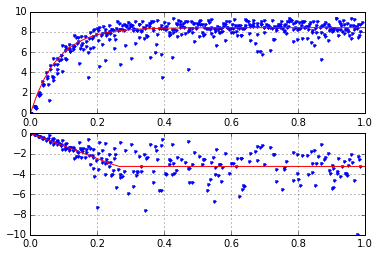

In [42]:
plt.subplot(2,1,1)
plt.plot(ttr,vtr,'.',np.linspace(0,Tt),omegabar*(1-np.exp(-lamb*np.linspace(0,Tt))),'r-')
plt.grid()

plt.subplot(2,1,2)
plt.plot(x,y,'.',
         np.linspace(0,Tt),np.maximum(-lamb*np.linspace(0,Tt),eta),'r-')
plt.grid()

## Identifying $J_m$

Repeat experiment with known $J_a$ then:
$$
(J_m + J_a) \, \dot{\omega} + b_m \, \omega = k_m \, (v_a - v_0)
$$
then:
$$
\begin{aligned}
a &= \frac{k_m}{b_m}, & \lambda_a &= \frac{b_m}{J_m + J_a} = \frac{1}{1 + J_a/J_m} \frac{b_m}{J_m} = \rho^{-1} \lambda, & \rho &= \frac{\lambda}{\lambda_a} = 1 + J_a/J_m
\end{aligned}
$$
From here:
\begin{aligned}
J_m &= \frac{J_a}{\rho - 1}, &
b_m &= \lambda \, J_m, &
k_m &= a \, b_m.
\end{aligned}



In [43]:
print('> Identifying motor dynamic response')
K = 5
T0 = 1
T1 = 2
tref = []
duty = 90
with controller:
    controller.set_sink('logger',reset=True)
    for k in range(K):
        print('\r  Experiment #{}'.format(k+1),end='')
        time.sleep(T0)
        t0=controller.get_signal('clock')
        controller.set_signal('motor1',duty)
        time.sleep(T1)
        t1=controller.get_signal('clock')
        controller.set_signal('motor1',0)
        time.sleep(T0)
        tref.append((t0,t1))
print('\n< Done')
print('> Retrieving data')
log = controller.read_sink('logger')
print('< Done')

> Identifying motor dynamic response
  Experiment #5
< Done
> Retrieving data
< Done


In [44]:
t = log[:,0]
pos = log[:,1]
ref = log[:,2]

vel = np.zeros(t.shape, float)
vel[1:] = (pos[1:]-pos[:-1])/(t[1:]-t[:-1])

/Users/mauricio/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: divide by zero encountered in true_divide


In [45]:
N = 0
omegabar = 0
for (tk,tr) in tref:
    indss = np.where((t > tk+Tt) & (t < tr))
    nss = len(indss[0])
    omegabar += nss * np.mean(vel[indss])
    N += nss
omegabar /= N
print('N = {}, omegabar = {:5.3f}[{:5.3f}]'.format(N, omegabar, a * (duty-v0)))

N = 409, omegabar = 8.123[8.591]


In [46]:
N = 0
vtr = np.array([])
ttr = np.array([])
for (tk,tr) in tref:
    indtr = np.where((t > tk + Ts) & (t < tk+Tt))
    vtr = np.hstack((vtr,vel[indtr]))
    ttr = np.hstack((ttr,t[indtr]-tk-Ts))

In [47]:
def func(x, a, b):
    return np.maximum(-a * x, b)

import scipy.optimize as optimize

x = ttr
y = np.log(1-vtr/omegabar)
ind = ~np.isnan(y)
x = x[ind]
y = y[ind]

pars, residues = optimize.curve_fit(func, x, y)
lamb_a, eta_a = pars
print('lambda_a = {:4.3f}, eta = {:4.3f}'.format(lamb_a,eta_a))

lambda_a = 11.538, eta = -2.772


/Users/mauricio/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:7: RuntimeWarning: invalid value encountered in log


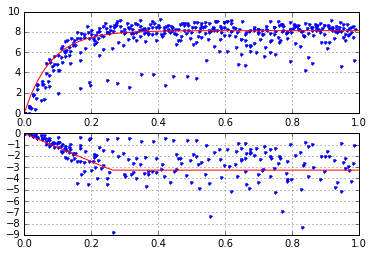

In [48]:
plt.subplot(2,1,1)
plt.plot(ttr,vtr,'.',np.linspace(0,Tt),omegabar*(1-np.exp(-lamb*np.linspace(0,Tt))),'r-')
plt.grid()

plt.subplot(2,1,2)
plt.plot(x,y,'.',
         np.linspace(0,Tt),np.maximum(-lamb*np.linspace(0,Tt),eta),'r-')
plt.grid()

In [49]:
#lamba = 12.9
ma = 60/1000
ra = 3.8/100
Ja = ma*ra**2/2
print('Ja = {:8.6f}'.format(Ja))

Ja = 0.000043


In [50]:
rho = lamb/lamb_a
Jm = Ja/(rho-1)
bm = lamb * Jm
km = a * bm
print('Jm = {:8.6f}, km = {:8.6f}, bm = {:8.6f}'.format(Jm,km,bm))

Jm = 0.000540, km = 0.000715, bm = 0.006735
